# CARGANDO MODELOS Y DATOS


IMPORTAR MODELO RANDOM FOREST Y DATOS

In [2]:
import joblib
import requests
import pandas as pd
import io
###OPTUNA
# URL directa al archivo .pkl
url1 = 'https://raw.githubusercontent.com/Mbenitez11/Prediccion-de-generacin-de-energia-solar-y-analisis-de-fallas/main/results/best_model.pkl'

# Descargar el archivo
response1 = requests.get(url1)

# Cargar el modelo desde el contenido descargado
best_model = joblib.load(io.BytesIO(response1.content))

###GRID SEARCH
# URL directa al archivo .pkl
url2 = 'https://raw.githubusercontent.com/Mbenitez11/Prediccion-de-generacin-de-energia-solar-y-analisis-de-fallas/main/results/best_model_grid.pkl'

# Descargar el archivo
response2 = requests.get(url2)

# Cargar el modelo desde el contenido descargado
best_model_grid = joblib.load(io.BytesIO(response2.content))


###RANDOM FOREST SIN OPTIMIZACION DE HIPERPARAMETROS
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor()



In [3]:
# Cargar los datos

url_X_train='https://github.com/Mbenitez11/Prediccion-de-generacin-de-energia-solar-y-analisis-de-fallas/raw/refs/heads/main/results/X_train.pkl'
url_X_test='https://github.com/Mbenitez11/Prediccion-de-generacin-de-energia-solar-y-analisis-de-fallas/raw/refs/heads/main/results/X_test.pkl'
url_y_train='https://github.com/Mbenitez11/Prediccion-de-generacin-de-energia-solar-y-analisis-de-fallas/raw/refs/heads/main/results/y_train.pkl'
url_y_test='https://github.com/Mbenitez11/Prediccion-de-generacin-de-energia-solar-y-analisis-de-fallas/raw/refs/heads/main/results/y_test.pkl'
url_X1='https://github.com/Mbenitez11/Prediccion-de-generacin-de-energia-solar-y-analisis-de-fallas/raw/refs/heads/main/results/X1.pkl'
url_y1='https://github.com/Mbenitez11/Prediccion-de-generacin-de-energia-solar-y-analisis-de-fallas/raw/refs/heads/main/results/y1.pkl'

response1= requests.get(url_X_train)
response2=requests.get(url_X_test)
response3=requests.get(url_y_train)
response4=requests.get(url_y_test)
response5= requests.get(url_X1)
response6=requests.get(url_y1)

X_train = joblib.load(io.BytesIO(response1.content))
X_test = joblib.load(io.BytesIO(response2.content))
y_train = joblib.load(io.BytesIO(response3.content))
y_test = joblib.load(io.BytesIO(response4.content))
X1 = joblib.load(io.BytesIO(response5.content))
y1 = joblib.load(io.BytesIO(response6.content))

In [4]:
rfr.fit(X_train,y_train)

RandomForestRegressor()

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
prediction_normal=rfr.predict(X_test)
prediction_optuna = best_model.predict(X_test)
prediction_grid = best_model_grid.predict(X_test)

In [8]:
cross_checking = pd.DataFrame({'Actual' : y_test['DC_POWER'] , 'Predicted_normal' : prediction_normal[:, 0], 'Predicted_optuna' : prediction_optuna[:, 0], 'Predicted_grid' : prediction_grid[:, 0]})
cross_checking.iloc[1000:1005]

,Actual,Predicted_normal,Predicted_optuna,Predicted_grid
26793,0.000,0.00000,0.000000,0.000000
193079,0.000,0.00000,0.000000,0.000000
122040,2.627,2.56089,2.527312,2.372111
317014,0.000,0.00000,0.000000,0.000000
347138,0.000,0.00000,0.000000,0.000000


In [9]:

# Crear una columna de error con las condiciones especificadas
cross_checking['Error_normal'] = np.where(
    (cross_checking['Actual'] == 0) & (cross_checking['Actual'] - cross_checking['Predicted_normal'] == 0),
    0,
    np.where(
        (cross_checking['Actual'] == 0) & (cross_checking['Actual'] - cross_checking['Predicted_normal'] != 0),
        np.nan, # Reemplaza "Probablemente Apagado" con np.nan
        abs(cross_checking['Actual'] - cross_checking['Predicted_normal']) * 100 / cross_checking['Actual']
    )
)

cross_checking['Error_optuna'] = np.where(
    (cross_checking['Actual'] == 0) & (cross_checking['Actual'] - cross_checking['Predicted_optuna'] == 0),
    0,
    np.where(
        (cross_checking['Actual'] == 0) & (cross_checking['Actual'] - cross_checking['Predicted_optuna'] != 0),
        np.nan, # Reemplaza "Probablemente Apagado" con np.nan
        abs(cross_checking['Actual'] - cross_checking['Predicted_optuna']) * 100 / cross_checking['Actual']
    )
)

cross_checking['Error_grid'] = np.where(
    (cross_checking['Actual'] == 0) & (cross_checking['Actual'] - cross_checking['Predicted_grid'] == 0),
    0,
    np.where(
        (cross_checking['Actual'] == 0) & (cross_checking['Actual'] - cross_checking['Predicted_grid'] != 0),
        np.nan, # Reemplaza "Probablemente Apagado" con np.nan
        abs(cross_checking['Actual'] - cross_checking['Predicted_grid']) * 100 / cross_checking['Actual']
    )
)


# Aplicar formato de estilo con un gradiente de color personalizado para resaltar errores altos en rojo
cross_checking.sample(25).style.background_gradient(
    cmap='coolwarm', subset=['Error_normal', 'Error_optuna', 'Error_grid']
).set_properties(**{
    'font-family': 'Lucida Calligraphy',
    'color': 'DarkBlack',
    'font-size': '15px'
})

,Actual,Predicted_normal,Predicted_optuna,Predicted_grid,Error_normal,Error_optuna,Error_grid
351168,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
218071,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
167536,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
82075,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
431232,11.810000,12.305900,12.359296,12.376486,4.198984,4.651112,4.796668
152456,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
140076,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
359450,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
297589,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
41991,48.240000,46.823900,47.202078,46.839375,2.935531,2.151580,2.903451


In [10]:
X_test.head()

,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,WIND_SPEED,IRRADIATION,SEASON
333998,21.420,27.330,0.5,0.184200,1
23070,-7.025,-6.160,2.0,0.033430,2
28538,6.870,4.165,8.0,0.000460,2
266661,23.700,19.730,0.4,0.000437,4
1283,7.937,7.928,1.2,0.000322,2


In [11]:
cross_checking['IRRADIATION']=X_test['IRRADIATION']
cross_checking['MODULE_TEMPERATURE']=X_test['MODULE_TEMPERATURE']
cross_checking['AMBIENT_TEMPERATURE']=X_test['AMBIENT_TEMPERATURE']


In [12]:
cross_checking[['Actual','IRRADIATION','MODULE_TEMPERATURE','AMBIENT_TEMPERATURE','Error_normal', 'Error_optuna', 'Error_grid']].sample(25).style.background_gradient(
    cmap='coolwarm', subset=['Error_normal', 'Error_optuna', 'Error_grid']
).set_properties(**{
    'font-family': 'Lucida Calligraphy',
    'color': 'DarkBlack',
    'font-size': '15px'
})

,Actual,IRRADIATION,MODULE_TEMPERATURE,AMBIENT_TEMPERATURE,Error_normal,Error_optuna,Error_grid
296637,0.000000,0.000518,19.610000,20.330000,0.000000,0.000000,0.000000
378266,0.000000,0.000423,1.784000,5.470000,0.000000,0.000000,0.000000
315996,0.000000,0.000541,17.420000,20.050000,0.000000,0.000000,0.000000
84460,39.650000,0.626000,37.740000,8.530000,14.078689,9.958435,11.342842
10866,0.203000,0.009480,5.724000,6.231000,23.054187,7.444930,5.876962
190407,0.000000,0.000354,21.980000,25.110000,0.000000,0.000000,0.000000
372339,0.000000,0.000439,-1.954000,3.614000,0.000000,0.000000,0.000000
252785,37.130000,0.599200,54.980000,30.790000,0.001885,0.089930,0.343486
132986,0.000000,0.000407,3.368000,9.300000,0.000000,0.000000,0.000000
137659,0.000000,0.000448,12.810000,17.620000,0.000000,0.000000,0.000000


# **GRAFICAS**

Grafico de Dispersion

<ipython-input-13-0c1938f5fa63>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([cross_checking['Actual'].min(), cross_checking['Actual'].max()],


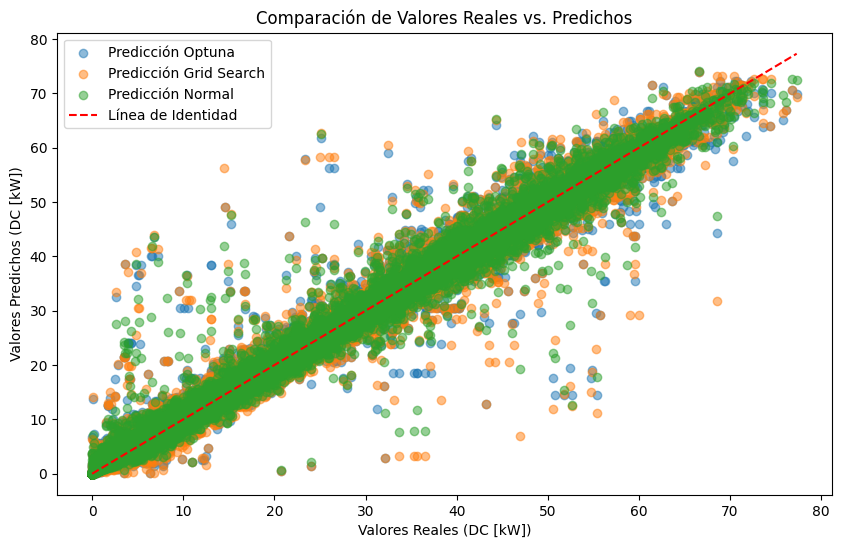

In [13]:

plt.figure(figsize=(10, 6))

plt.scatter(cross_checking['Actual'], cross_checking['Predicted_optuna'], alpha=0.5, label='Predicción Optuna')
plt.scatter(cross_checking['Actual'], cross_checking['Predicted_grid'], alpha=0.5, label='Predicción Grid Search')
plt.scatter(cross_checking['Actual'], cross_checking['Predicted_normal'], alpha=0.5, label='Predicción Normal')
plt.plot([cross_checking['Actual'].min(), cross_checking['Actual'].max()],
         [cross_checking['Actual'].min(), cross_checking['Actual'].max()],
         'k--', color='red', label='Línea de Identidad')
plt.xlabel('Valores Reales (DC [kW])')
plt.ylabel('Valores Predichos (DC [kW])')
plt.legend()
plt.title('Comparación de Valores Reales vs. Predichos')
plt.show()


Histograma de errores

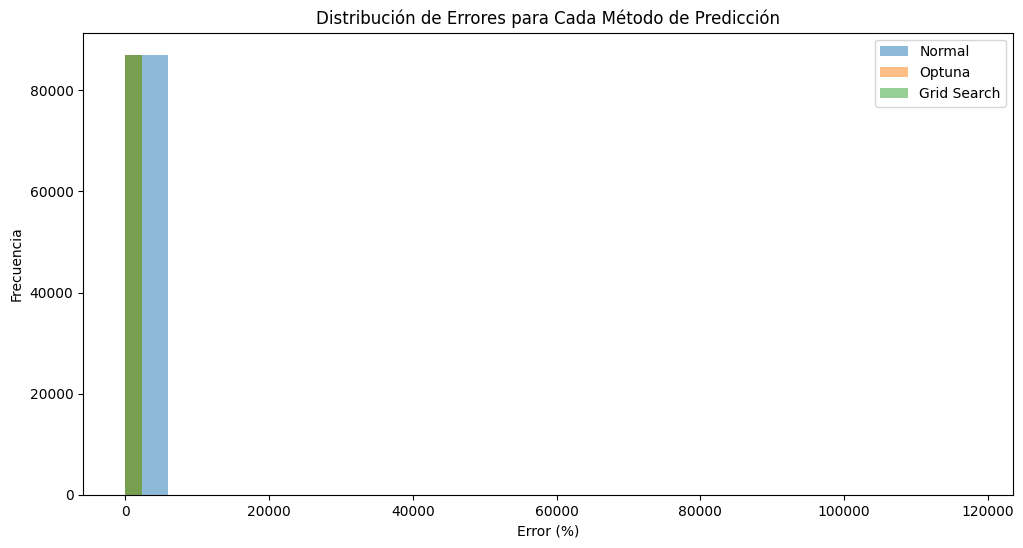

In [18]:
plt.figure(figsize=(12, 6))
plt.hist(cross_checking['Error_normal'], bins=20, alpha=0.5, label='Normal')
plt.hist(cross_checking['Error_optuna'], bins=20, alpha=0.5, label='Optuna')
plt.hist(cross_checking['Error_grid'], bins=20, alpha=0.5, label='Grid Search')


plt.xlabel('Error (%)')
plt.ylabel('Frecuencia')
plt.title('Distribución de Errores para Cada Método de Predicción')
plt.legend()
plt.show()


Gráfico de Barras Comparativo

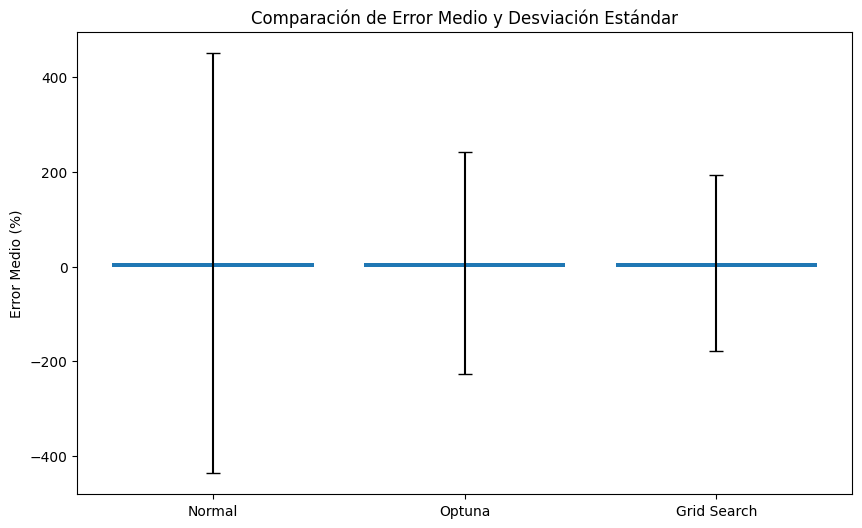

In [19]:

# Calcular la media y desviación estándar de los errores
mean_errors = [cross_checking['Error_normal'].mean(), cross_checking['Error_optuna'].mean(), cross_checking['Error_grid'].mean()]
std_errors = [cross_checking['Error_normal'].std(), cross_checking['Error_optuna'].std(), cross_checking['Error_grid'].std()]

# Crear el gráfico de barras con barras de error
plt.figure(figsize=(10, 6))
plt.bar(['Normal', 'Optuna', 'Grid Search'], mean_errors, yerr=std_errors, capsize=5)
plt.ylabel('Error Medio (%)')
plt.title('Comparación de Error Medio y Desviación Estándar')
plt.show()


Scatter Plot

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


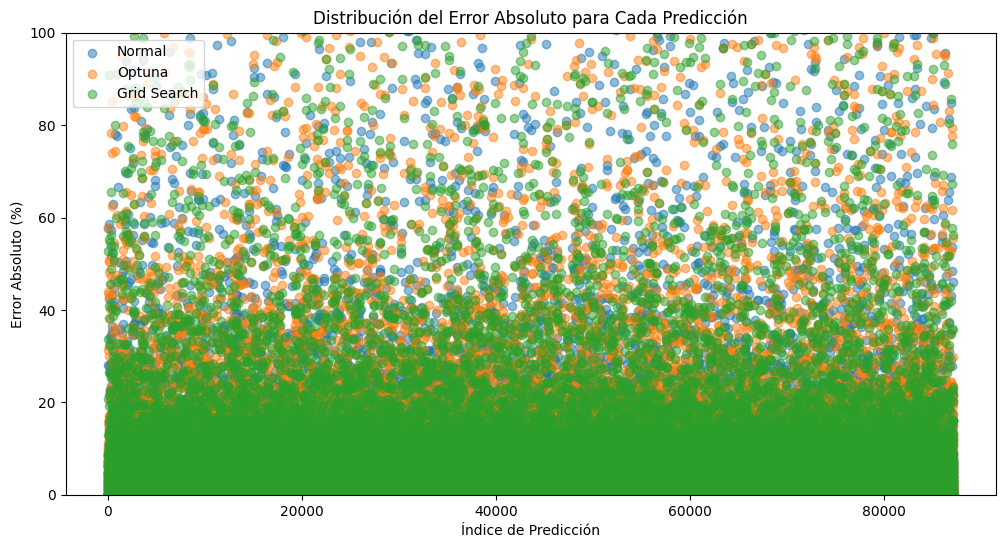

In [20]:
plt.figure(figsize=(12, 6))
plt.scatter(range(len(cross_checking['Error_normal'])), abs(cross_checking['Error_normal']), alpha=0.5, label='Normal')
plt.scatter(range(len(cross_checking['Error_optuna'])), abs(cross_checking['Error_optuna']), alpha=0.5, label='Optuna')
plt.scatter(range(len(cross_checking['Error_grid'])), abs(cross_checking['Error_grid']), alpha=0.5, label='Grid Search')
plt.ylim(0, 100)
plt.xlabel('Índice de Predicción')
plt.ylabel('Error Absoluto (%)')
plt.title('Distribución del Error Absoluto para Cada Predicción')
plt.legend()
plt.show()


Violin Plot

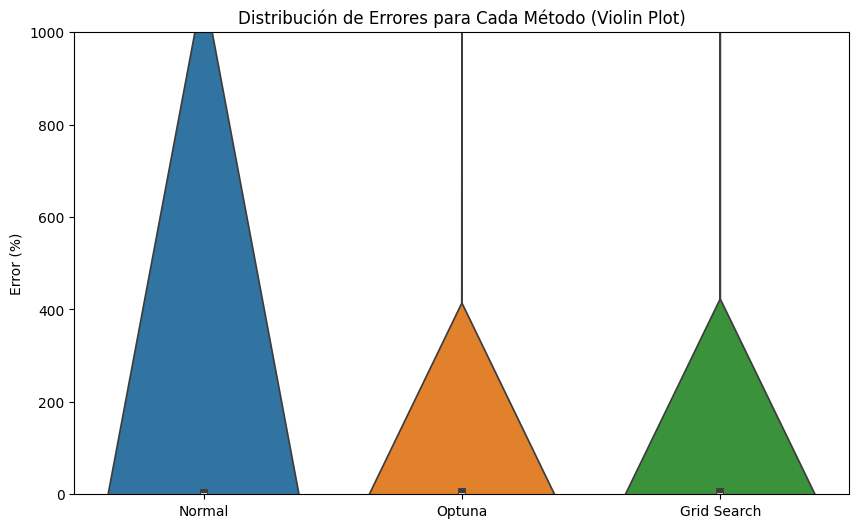

In [23]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.violinplot(data=[cross_checking['Error_normal'], cross_checking['Error_optuna'], cross_checking['Error_grid']])
plt.xticks([0, 1, 2], ['Normal', 'Optuna', 'Grid Search'])
plt.ylim(0, 1000)
plt.ylabel('Error (%)')
plt.title('Distribución de Errores para Cada Método (Violin Plot)')
plt.show()


Gráfico KDE

<ipython-input-27-aec1aed6d525>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cross_checking['Error_normal'], label='Normal', shade=True)
<ipython-input-27-aec1aed6d525>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cross_checking['Error_optuna'], label='Optuna', shade=True)
<ipython-input-27-aec1aed6d525>:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(cross_checking['Error_grid'], label='Grid Search', shade=True)


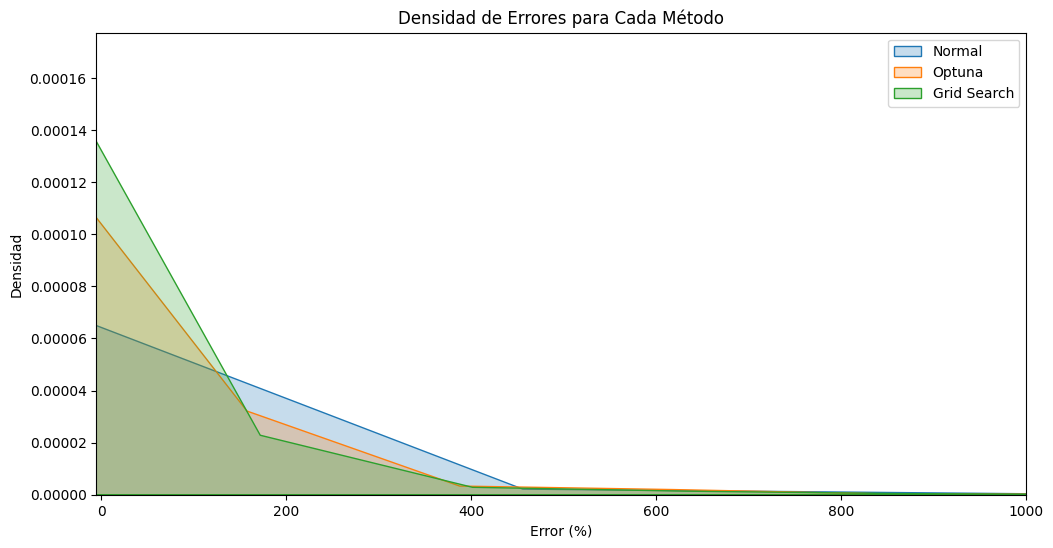

In [27]:
plt.figure(figsize=(12, 6))
sns.kdeplot(cross_checking['Error_normal'], label='Normal', shade=True)
sns.kdeplot(cross_checking['Error_optuna'], label='Optuna', shade=True)
sns.kdeplot(cross_checking['Error_grid'], label='Grid Search', shade=True)
plt.xlim(-5, 1000)
plt.xlabel('Error (%)')
plt.ylabel('Densidad')
plt.title('Densidad de Errores para Cada Método')
plt.legend()
plt.show()


Grafico CDF

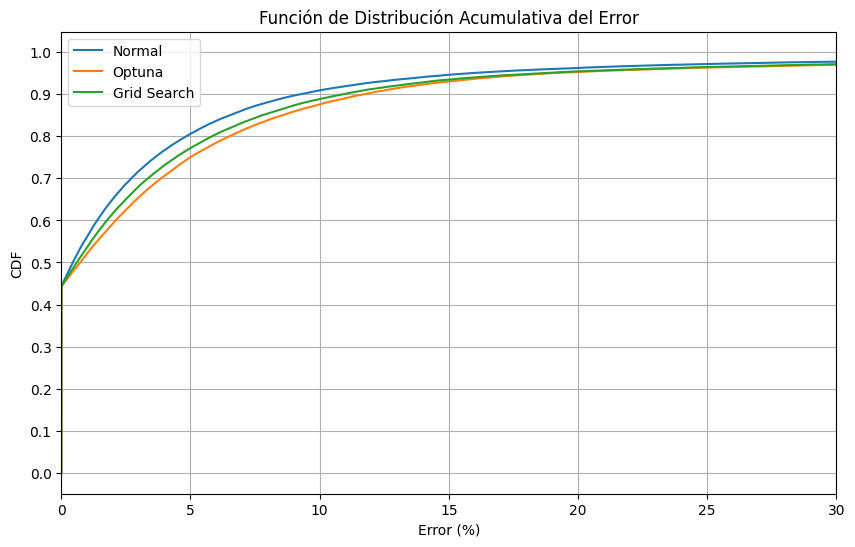

In [30]:


plt.figure(figsize=(10, 6))
for errors, label in zip([cross_checking['Error_normal'], cross_checking['Error_optuna'], cross_checking['Error_grid']],
                         ['Normal', 'Optuna', 'Grid Search']):
    sorted_errors = np.sort(errors)
    yvals = np.arange(len(sorted_errors)) / float(len(sorted_errors))
    plt.plot(sorted_errors, yvals, label=label)
plt.xlim(0, 30)
plt.xlabel('Error (%)')
plt.ylabel('CDF')
plt.title('Función de Distribución Acumulativa del Error')
plt.legend()


plt.yticks(np.arange(0, 1.1, 0.1))  # Cambia el rango y los intervalos del eje y
plt.grid(True)
plt.show()


# APLICACIONES

 1. Optimización de la operación de plantas solares:
    - Predecir la generación de energía con antelación, permitiendo una mejor gestión de la producción y distribución de energía.
   - Identificar patrones de generación y anticipar posibles fluctuaciones, optimizando el uso de recursos y evitando pérdidas.
 2. Toma de decisiones estratégicas en la inversión en energía solar:
   - Evaluar la rentabilidad de proyectos de energía solar en diferentes ubicaciones y condiciones climáticas.
    -  Aportar información crucial para inversores y desarrolladores de proyectos, minimizando riesgos y maximizando retornos.

 3.  Monitoreo y mantenimiento predictivo:
    -  Detectar anomalías en la generación de energía que podrían indicar fallas o problemas técnicos.
    -  Permitir una intervención temprana para evitar interrupciones en la producción y minimizar costos de mantenimiento.

 4. Integración con sistemas de gestión de energía:
    -  Integrar el modelo en sistemas de gestión de energía más amplios para optimizar la gestión del consumo y la generación.
    -  Facilitar la integración de la energía solar con otras fuentes de energía, mejorando la eficiencia del sistema.

 5. Análisis del impacto de variables climáticas:
    - Analizar la influencia de variables climáticas como la radiación solar, la temperatura ambiente y la temperatura del módulo en la generación de energía.
    -  Mejorar la precisión de las predicciones y adaptar las estrategias de gestión a las condiciones climáticas específicas.

 6.  Planificación de la expansión de la infraestructura solar:#    - Informar decisiones sobre la expansión de la infraestructura de generación de energía solar, considerando las predicciones de generación y las necesidades de consumo.
    -  Optimizar la ubicación y el tamaño de nuevas plantas solares para maximizar su impacto.

 7.  Estudios de impacto ambiental:
    - Evaluar el impacto ambiental de la energía solar y contribuir al desarrollo de proyectos sostenibles.
   -  Contribuir al desarrollo de modelos de gestión de energía más responsables con el medio ambiente.

 Ejemplo de uso:

 Predecir la generación de energía para las siguientes 24 horas utilizando los datos climáticos disponibles.
 Los datos deben incluir radiación solar, temperatura del módulo, y temperatura ambiente.

In [31]:
solar_data = pd.read_csv('https://raw.githubusercontent.com/Mbenitez11/Prediccion-de-generacin-de-energia-solar-y-analisis-de-fallas/refs/heads/main/data/SolarPrediction.csv')

In [32]:
solar_data.head()

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00


In [33]:
solar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32686 entries, 0 to 32685
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   UNIXTime                32686 non-null  int64  
 1   Data                    32686 non-null  object 
 2   Time                    32686 non-null  object 
 3   Radiation               32686 non-null  float64
 4   Temperature             32686 non-null  int64  
 5   Pressure                32686 non-null  float64
 6   Humidity                32686 non-null  int64  
 7   WindDirection(Degrees)  32686 non-null  float64
 8   Speed                   32686 non-null  float64
 9   TimeSunRise             32686 non-null  object 
 10  TimeSunSet              32686 non-null  object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ MB


In [34]:
solar_data['Data'] = pd.to_datetime(solar_data['Data'], format='%m/%d/%Y %I:%M:%S %p')

In [35]:
solar_data.isnull().sum()

,0
UNIXTime,0
Data,0
Time,0
Radiation,0
Temperature,0
Pressure,0
Humidity,0
WindDirection(Degrees),0
Speed,0
TimeSunRise,0


In [36]:
X_train.head()


,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,WIND_SPEED,IRRADIATION,SEASON
189849,30.890,32.400,1.4,0.04958,4
303125,20.900,16.150,1.6,0.00129,1
90280,5.550,21.820,10.1,0.64720,3
45688,3.481,6.894,2.4,0.21850,2
430217,4.109,6.209,1.0,0.09570,2


In [53]:
import random
df_solar = pd.DataFrame({'DATE_TIME' : solar_data['Data'], 'AMBIENT_TEMPERATURE' : solar_data['Temperature'], 'MODULE_TEMPERATURE' : solar_data['Temperature'],'WIND_SPEED' : solar_data['Speed'], 'IRRADIATION' : solar_data['Radiation'].astype('float')/1000, 'SEASON' : 4})

In [54]:
df_solar.head()

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,WIND_SPEED,IRRADIATION,SEASON
0,2016-09-29,48,48,5.62,0.00121,4
1,2016-09-29,48,48,3.37,0.00121,4
2,2016-09-29,48,48,3.37,0.00123,4
3,2016-09-29,48,48,3.37,0.00121,4
4,2016-09-29,48,48,5.62,0.00117,4


In [55]:
prediction=rfr.predict(df_solar[['AMBIENT_TEMPERATURE',	'MODULE_TEMPERATURE','WIND_SPEED',	'IRRADIATION','SEASON']])

In [56]:
prediction

array([[0.     , 0.00329],
       [0.     , 0.00345],
       [0.     , 0.00345],
       ...,
       [0.     , 0.00329],
       [0.     , 0.00329],
       [0.     , 0.00345]])

In [57]:
df_solar['DC_POWER']=prediction[:, 0]
df_solar['DC_CURRENT']=prediction[:, 1]

In [58]:
df_solar.iloc[1000:1010]

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,WIND_SPEED,IRRADIATION,SEASON,DC_POWER,DC_CURRENT
1000,2016-09-26,57,57,10.12,0.75701,4,45.0047,140.7623
1001,2016-09-26,57,57,4.50,0.73870,4,44.4902,140.8995
1002,2016-09-26,58,58,10.12,0.72383,4,42.7971,136.0858
1003,2016-09-26,58,58,9.00,0.70722,4,42.2697,134.1726
1004,2016-09-26,57,57,9.00,0.68700,4,41.9295,132.4583
1005,2016-09-26,57,57,7.87,0.66603,4,40.8652,129.0771
1006,2016-09-26,57,57,7.87,0.65038,4,40.5829,128.1888
1007,2016-09-26,57,57,7.87,0.62999,4,37.2461,117.2668
1008,2016-09-26,56,56,3.37,0.61068,4,37.1300,115.3448
1009,2016-09-26,56,56,4.50,0.59188,4,36.3015,113.6782


In [59]:
df_solar["DATE"] = pd.to_datetime(df_solar["DATE_TIME"]).dt.date
df_solar["TIME"] = pd.to_datetime(df_solar["DATE_TIME"]).dt.time
df_solar['DAY'] = pd.to_datetime(df_solar['DATE_TIME']).dt.day
df_solar['MONTH'] = pd.to_datetime(df_solar['DATE_TIME']).dt.month
df_solar['WEEK'] = pd.to_datetime(df_solar['DATE_TIME']).dt.isocalendar().week # Use isocalendar().week instead of week

# add hours and minutes for ml models
df_solar['HOURS'] = pd.to_datetime(df_solar['TIME'],format='%H:%M:%S').dt.hour
df_solar['MINUTES'] = pd.to_datetime(df_solar['TIME'],format='%H:%M:%S').dt.minute
df_solar['TOTAL MINUTES PASS'] = df_solar['MINUTES'] + df_solar['HOURS']*60

# add date as string column
df_solar["DATE_STRING"] = df_solar["DATE"].astype(str) # add column with date as string
df_solar["HOURS"] = df_solar["HOURS"].astype(str)
df_solar["TIME"] = df_solar["TIME"].astype(str)

df_solar.iloc[1000:1010]

,DATE_TIME,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,WIND_SPEED,IRRADIATION,SEASON,DC_POWER,DC_CURRENT,DATE,TIME,DAY,MONTH,WEEK,HOURS,MINUTES,TOTAL MINUTES PASS,DATE_STRING
1000,2016-09-26,57,57,10.12,0.75701,4,45.0047,140.7623,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1001,2016-09-26,57,57,4.50,0.73870,4,44.4902,140.8995,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1002,2016-09-26,58,58,10.12,0.72383,4,42.7971,136.0858,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1003,2016-09-26,58,58,9.00,0.70722,4,42.2697,134.1726,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1004,2016-09-26,57,57,9.00,0.68700,4,41.9295,132.4583,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1005,2016-09-26,57,57,7.87,0.66603,4,40.8652,129.0771,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1006,2016-09-26,57,57,7.87,0.65038,4,40.5829,128.1888,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1007,2016-09-26,57,57,7.87,0.62999,4,37.2461,117.2668,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1008,2016-09-26,56,56,3.37,0.61068,4,37.1300,115.3448,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26
1009,2016-09-26,56,56,4.50,0.59188,4,36.3015,113.6782,2016-09-26,00:00:00,26,9,39,0,0,0,2016-09-26


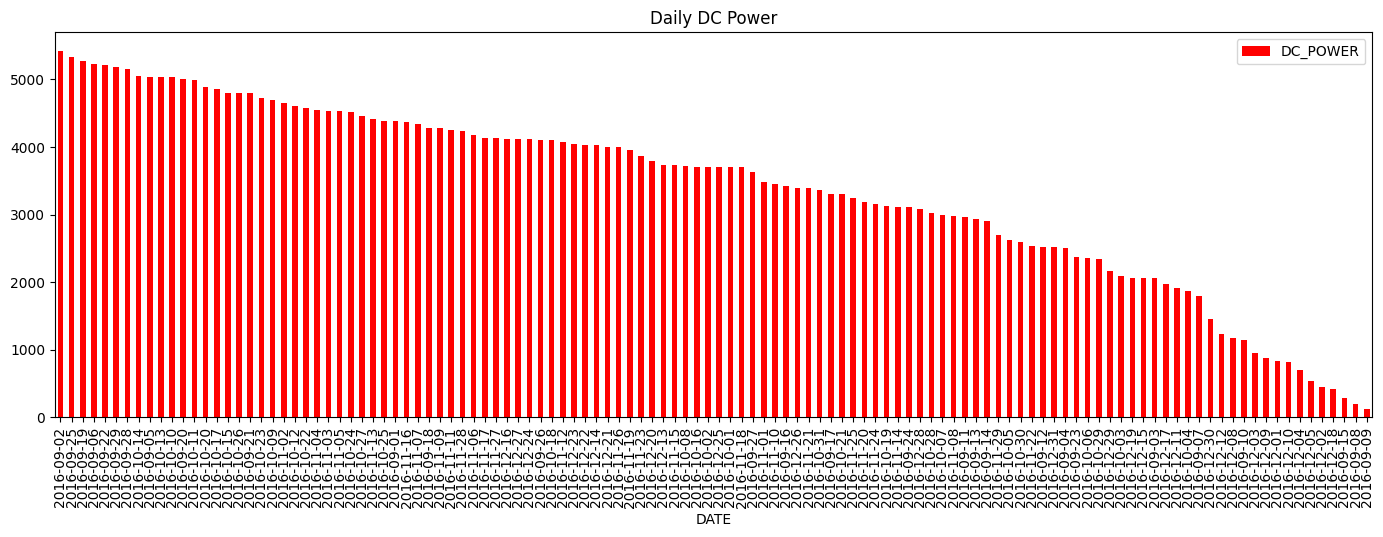

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


daily_dc = df_solar.groupby('DATE')['DC_POWER'].agg('sum')

ax = daily_dc.sort_values(ascending=False).plot.bar(figsize=(17,5), legend=True,color='red')
plt.title('Daily DC Power')
plt.show()

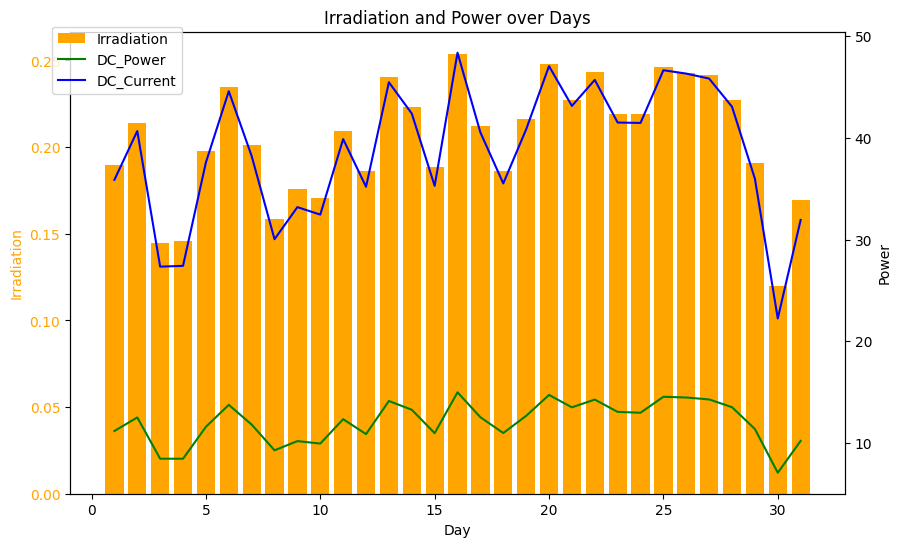

In [64]:

# Filtrar datos y crear el día de cada fecha
df_solar['Day'] = df_solar['DATE_TIME'].dt.day
dc_power = df_solar.groupby('Day')['DC_POWER'].mean()
dc_cr= df_solar.groupby('Day')['DC_CURRENT'].mean()
irradiation = df_solar.groupby('Day')['IRRADIATION'].mean()

# Crear gráfico
fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfico de Irradiation
ax1.bar(irradiation.index, irradiation.values, color='orange', label='Irradiation')
ax1.set_xlabel('Day')
ax1.set_ylabel('Irradiation', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')

# Crear segundo eje y graficar DC y AC Power
ax2 = ax1.twinx()
ax2.plot(dc_power.index, dc_power.values, color='green', label='DC_Power')
ax2.plot(dc_cr.index, dc_cr.values, color='blue', label='DC_Current')
ax2.set_ylabel('Power', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Agregar leyenda
fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))
plt.title('Irradiation and Power over Days')
plt.show()